# Tree Models



### Organizational

#### What you will learn
- Visualizing decision trees
- Interpreting trees
- Implementing BestSplit rules
- Implementing a decision tree
- Configuring your tree model using cross-validation

#### What to submit
Read this notebook and do the exercises. Then, do the following:

* Copy your exercise solutions into the skeleton code in `A2.py`, and you can test it with `A2_test.py`. When you're satisfied that your code in `A2.py` passes the tests, commit and push it back to **Github**.

* Make a PDF report answers to the open questions (as well as your graphics). You can use `A2_STUDENTNUMBER.tex` as a template to make it in Overleaf if you wish. It should be named `A2_s1234567890.pdf`, but using your own student number instead of 1234567890. Hand the PDF report in through **Brightspace**.

    Your answers don't need to be long, just be to the point. The report should under no circumstances be more than 1 page of text, taking an extra page to make room for graphics is ok.

* **If you do not submit both `A2.py` to Github and the PDF report to Brightspace, you will fail this assignment.**

* **This is an individual assignment. Your code and report must be your own work.**

#### How do we grade?
* 7 Open questions, including images. You can earn a bonus point for completely answering question 5.    Remember, all figures and tables should have a caption.

* We test the functioning of your code with 12 unit tests, one of which (for minority_class) already passes, so 11 tests that are about your work.

* 50% of the grade is based on the questions and 50% on the exercises.

## Setting up

If you need to install graphviz, the following code will work for Google Colab. 

Note that you're installing two things:
* A backend, that renders the graphics
* A Python frontend that allows you to use it in the middle of your program

In [39]:
# Installing dependencies (on Colab for example)
!pip install graphviz
!pip install pytest

To download graphviz, follow the relevant instructions (based on your operating system) [here](https://www.graphviz.org/download/).
For Windows users: You can download the latest version of Graphviz listed on the website. Make sure to add Graphviz to the system PATH when installing.

Then, on Windows, open a terminal (for example windows powershell) and type in the command py -m pip install graphviz. This should install graphviz and make it possible for the code to import the package.
You can find more extensive installation instructions for graphviz on different operating systems [here](https://pypi.org/project/graphviz/).

Import (and if necessary, first install) the following packages to get started. You don't need to import other packages.

In [40]:
import numpy as np
import pandas as pd
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.metrics import accuracy_score
import pytest

## Visualization


One of the key selling points of decision trees is that they're much easier to interpret than many other models. While for example a neural network is essentially a "black box", you can look at a decision tree and trace the logic. 

First we need a dataset.

In [41]:
# Dataset adapted from https://archive.ics.uci.edu/ml/datasets/Zoo
url = 'https://raw.githubusercontent.com/MLCourse-LU/Datasets/main/zoo.csv'
df = pd.read_csv(filepath_or_buffer=url, header=0, index_col=0)


X = df.iloc[:, 1:-1]  # column 0 has the animal names, the last column has the labels
y = df.iloc[:, -1]  # use the last column as labels

fn = list(X.columns)  # get the column names of the features
cn = y.unique()  # get the different animal labels from the target column

Let's get a quick impression of what's in here. **You may need to scroll to the right** to see the "type" column which we use as class label.

In [42]:
print(df.info())
print(df.describe())
df

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 100
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   animal name  101 non-null    object
 1   hair         101 non-null    int64 
 2   feathers     101 non-null    int64 
 3   eggs         101 non-null    int64 
 4   milk         101 non-null    int64 
 5   airborne     101 non-null    int64 
 6   aquatic      101 non-null    int64 
 7   predator     101 non-null    int64 
 8   toothed      101 non-null    int64 
 9   backbone     101 non-null    int64 
 10  breathes     101 non-null    int64 
 11  venomous     101 non-null    int64 
 12  fins         101 non-null    int64 
 13  legs         101 non-null    int64 
 14  tail         101 non-null    int64 
 15  domestic     101 non-null    int64 
 16  catsize      101 non-null    int64 
 17  type         101 non-null    object
dtypes: int64(16), object(2)
memory usage: 15.0+ KB
None
             hair    fe

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
ID,,,,,,,,,,,,,,,,,,
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,1,0,0,1,Mammal
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,1,1,0,1,Mammal
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,Fish
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,1,0,0,1,Mammal
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,1,1,0,1,Mammal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,1,1,0,1,Mammal
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,Bug
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,1,1,0,1,Mammal


We have some data, nice. Now let's build a model. Just for demonstration purposes, we're using the whole dataset, but normally you'd be splitting between training and test sets.

In [43]:
model = DecisionTreeClassifier()
model.fit(X, y)  # train on the WHOLE dataset
# get wrong predictions instances

DecisionTreeClassifier()

Now we can visualize it in a couple of ways. First as text:

### Text visualization

In [44]:
# Show the model as text
print(export_text(model, feature_names=fn))

|--- milk <= 0.50
|   |--- feathers <= 0.50
|   |   |--- fins <= 0.50
|   |   |   |--- backbone <= 0.50
|   |   |   |   |--- airborne <= 0.50
|   |   |   |   |   |--- predator <= 0.50
|   |   |   |   |   |   |--- legs <= 0.50
|   |   |   |   |   |   |   |--- class: Invertebrate
|   |   |   |   |   |   |--- legs >  0.50
|   |   |   |   |   |   |   |--- class: Bug
|   |   |   |   |   |--- predator >  0.50
|   |   |   |   |   |   |--- class: Invertebrate
|   |   |   |   |--- airborne >  0.50
|   |   |   |   |   |--- class: Bug
|   |   |   |--- backbone >  0.50
|   |   |   |   |--- aquatic <= 0.50
|   |   |   |   |   |--- class: Reptile
|   |   |   |   |--- aquatic >  0.50
|   |   |   |   |   |--- eggs <= 0.50
|   |   |   |   |   |   |--- class: Reptile
|   |   |   |   |   |--- eggs >  0.50
|   |   |   |   |   |   |--- class: Amphibian
|   |   |--- fins >  0.50
|   |   |   |--- class: Fish
|   |--- feathers >  0.50
|   |   |--- class: Bird
|--- milk >  0.50
|   |--- class: Mammal



This makes sense - we can see at the bottom for example that if `milk > 0.5` holds, which means the animal produces milk, then it's a mammal.

### Graphical visualization

Then we use graphviz. Graphviz is a graphics package designed for handling graphs - like figuring out where to put notes so it all fits on the paper. This goes in a couple of steps:

In [45]:
# Use the sklearn.tree.export_graphviz method to export the tree in "dot" format
dot = export_graphviz(
    decision_tree=model,  # the tree to visualize
    out_file=None,  # if None, return it as a string with "dot" information
    feature_names=fn,  # list of feature names
    class_names=sorted(cn),  # sorted! list of class names
    filled=True  # pretty colors
)

print(dot)  # "dot" is a string containing a structural description of our future graphic:

digraph Tree {
node [shape=box, style="filled", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="milk <= 0.5\ngini = 0.759\nsamples = 101\nvalue = [4, 20, 8, 13, 10, 41, 5]\nclass = Mammal", fillcolor="#ebccf8"] ;
1 [label="feathers <= 0.5\ngini = 0.785\nsamples = 60\nvalue = [4, 20, 8, 13, 10, 0, 5]\nclass = Bird", fillcolor="#f4fbe2"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="fins <= 0.5\ngini = 0.766\nsamples = 40\nvalue = [4, 0, 8, 13, 10, 0, 5]\nclass = Fish", fillcolor="#ebfcfc"] ;
1 -> 2 ;
3 [label="backbone <= 0.5\ngini = 0.719\nsamples = 27\nvalue = [4, 0, 8, 0, 10, 0, 5]\nclass = Invertebrate", fillcolor="#eaedfc"] ;
2 -> 3 ;
4 [label="airborne <= 0.5\ngini = 0.494\nsamples = 18\nvalue = [0, 0, 8, 0, 10, 0, 0]\nclass = Invertebrate", fillcolor="#d7ddfa"] ;
3 -> 4 ;
5 [label="predator <= 0.5\ngini = 0.278\nsamples = 12\nvalue = [0, 0, 2, 0, 10, 0, 0]\nclass = Invertebrate", fillcolor="#6178ea"] ;
4 -> 5 ;
6 [label="

That's not really intended for humans to read, but for transferring it to the graphviz program to work with:

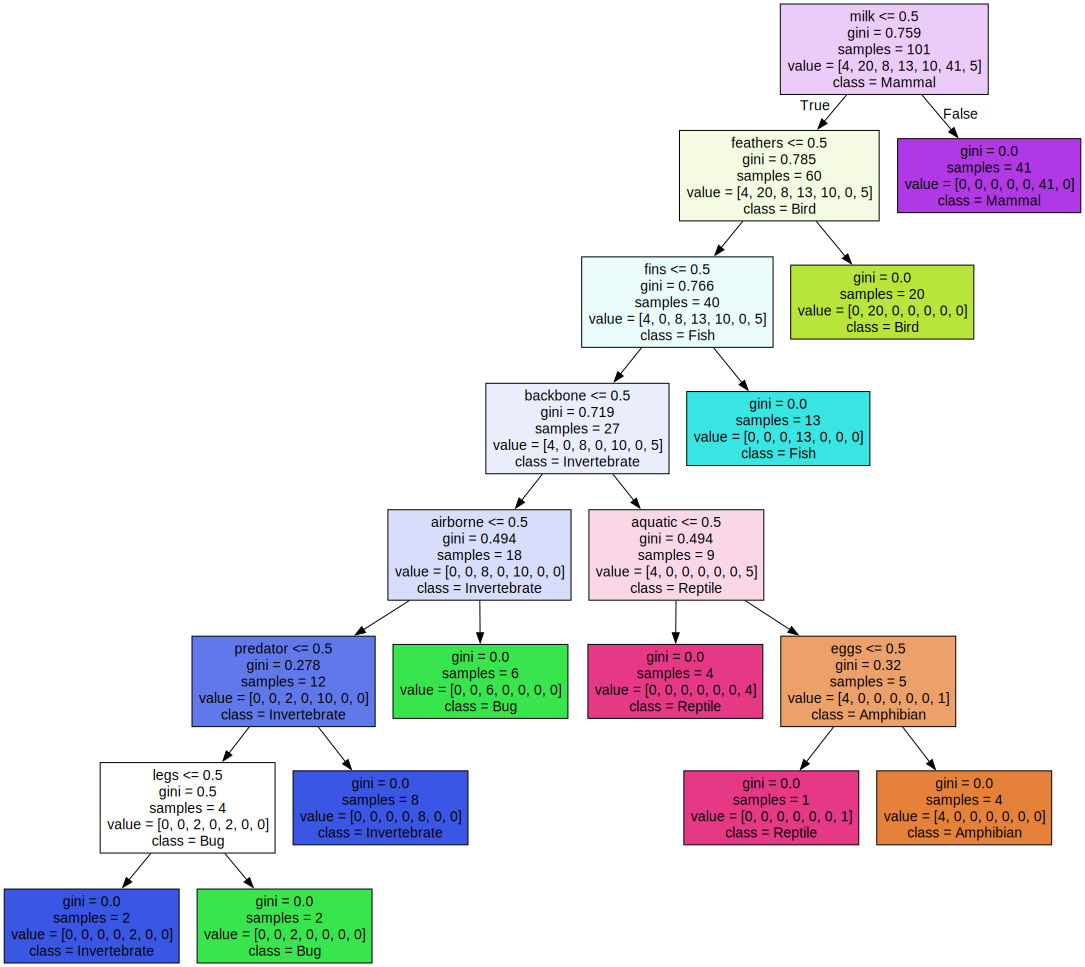

In [46]:
# Load the dot information into a graphviz object
graph = graphviz.Source(dot)

# Print a copy to disk
graph.render('graphviz-tree', format='pdf', cleanup=True)  # save it as a file and clean up helper files

# Show the result if using a Notebook
graph

## Interpretation

Let's analyze this graph. At the top node, we see the following:

```
milk <= 0.5 
gini = 0.759 
samples = 101 
value = [4, 20, 8, 13, 10, 41, 5] 
class = Mammal
```

* The first line, `milk <= 0.5` means that if the value of an instance's "milk" feature is 0.5 or lower, it counts as True and goes to the left of the tree, and if False, goes to the right of the tree.

* `gini` refers to the Gini index score of this node. This is a score we're trying to minimize. The current score isn't very good.

* `Samples = 101` means we have 101 animals in our training data.

* `value = [4, 20, 8, 13, 10, 41, 5]` shows us the class distribution of these samples. These are sorted alphabetically by class name, so that is `['Amphibian', 'Bird', 'Bug', 'Fish', 'Invertebrate', 'Mammal', 'Reptile']`. Looks like this zoo has a lot of mammals.

* `class` indicates the most likely class for a random sample from this node to belong to. If we grabbed a random animal from the zoo, it's most likely a mammal, since they make up 40% of the animals.

Then let's go to the right of the top node. These are the animals for which `milk <= 0.5` was False, in other words, the animal produces milk. We see the following:

```
gini = 0.0 
samples = 41 
value = [0, 0, 0, 0, 0, 41, 0] 
class = Mammal
```

* We have only 4 lines here, because this node isn't being split further. Why not? Well...
* The Gini index is 0. This means there's absolutely no confusion about what class instances in this node belong to.
* 41 samples, and only one of the classes in the `value` list has all of those samples. Everything in this node belongs to the same type of animal.
* This node predicts Mammals. Which makes sense: mammals are by definition the only kind of animals that produce milk. They're also a significant part of the zoo's population so making this split is a powerful move for the algorithm.

We repeat a similar process on the left subtree: only birds have feathers so they're split off. Only fish have scales so they're split off.

Then we come to `backbone` and at this point, the tree splits into two true subtrees. Here we can also see that the subtrees don't have to pick the same splitting criteria. Apparently for creatures without backbone (and that don't produce milk, don't have feathers, don't have fins), it's more relevant to ask whether they're airborne, while for creatures with a backbone (and that don't produce milk, don't have feathers, don't have fins) it matters more whether they're aquatic.

### Open questions


#### Question 1: Why does this model place "feathers" earlier in the tree than "airborne"?

#### Question 2: How could you find the instances in the dataset that end up in a particular leaf, but are misclassified?

## Splitting Rules



In a decision tree, we need rules that tell us when to split, and which split is best. For what we use impurity measures, that tell us how badly we're currently doing. If after a split we'd be doing less badly, then that's a good split to apply.


### Minority class
Using minority class as an impurity measure assumes that you classify each node with the majority class of instances in that node. So if the contents of a leaf node are `A, A, A, B, B` you would predict any test examples that end up in that leaf node to have class `A`, but you'd only be right $3/5$th of the time. So this node would have a quality of $1 - 3/5 = 0.4$.

If you could split this node so that one node had `A, B, B` and the other `A, A`, then the first one would have a base quality of $2/3$ because we're predicting that node's majority class `B`, and the other a base quality of $2/2$. Adding weights for their size, you'd get $1 - (0.6 \times \frac{2}{3} + 0.4 \times \frac{2}{2}) = 1 -(0.4 + 0.4) = 0.2$, so this is certainly a split we'd be willing to make.

Let's describe this a bit more formally.

Let $M$ be the ordered set of classes and $||M||$ the number of classes. $M$ is ordered by frequency. Then $M_i$ is the $i$-th class by frequency, and $M_1$ is the most frequent class. To cover the special case where there is a tie for most frequent class (like in a 50/50 split dataset), we just randomly pick one of them to be indexed as $j=1$.

Let $I$ be the set of all  instances in the dataset and $I_j$ the set of instances of class $j$. This allows us to define the probability that a randomly sampled instance belongs to $j$ as:

$$p_i = \frac{||I_j||}{||I||}$$

We can now define the minority class impurity measure as:

$$minority\_class = \sum_{j = 2}^{||M||} p_j$$

This is of course equal to $1 - p_1$, the probability of *not* sampling the ranked-first class. Note also that the most frequent class doesn't necessarily cover a majority of the dataset, so the name of this impurity measure is a little bit deceptive when we're not dealing with binary classification!

In [47]:
def minority_class(labels):
    if len(labels) == 0:
        return 0
    frequencies = labels.value_counts().values  # array, sorted in descending order
    probabilities = [f / len(labels) for f in frequencies[1:]]   # everything except the first class
    impurity = sum(probabilities)
    return impurity

### Gini index

Gini index, also called Gini impurity, should not be confused with Gini coefficient. Both are named after the statistician Corrado Gini.

The central idea is as follows. If a node is "pure", that is, all instances in it belong to the same class, then predicting the class of an instance is trivial. A pure node has a Gini index of 0. If a node isn't pure yet - meaning it has instances of more than one class in it, then we can calculate just how hard it is to classify instances in that node.

Suppose we know the distribution of class labels in a node. For example, we could have a node with `A, A, A, A, A, A, B, B, B, B` in it. Then if we grabbed a random instance, we'd have 60% chance of `A` and 40% chance of `B`. Now suppose we get a new instance and we have to predict its label, and we use those probabilities that we know. So there's a 60% chance that we predict `A`, and 40% chance that we predict `B`. Now, how often are we wrong? That's what Gini impurity measures.

The odds of us being wrong are those of predicting `A` but getting `B` ($0.6 \times 0.4 = 0.24$) and of predicting `B` but getting `A` ($0.4 \times 0.6 = 0.24$), so a total of $0.24 + 0.24 = 0.48$. This is the same as 1 minus the chance of us getting it right, so $1 - (0.6^2 + 0.4^2) = 0.48$.

Now imagine we have a proposed split of this node, that would result in child nodes `A, B, B, B, B` and `A, A, A, A, A`. The odds of getting it wrong in the first node are $1 - (0.2^2 + 0.8^2) = 0.32$. For the other node, the odds of getting it wrong are 0, because there's only one class to choose from. Their weights are each $\frac{5}{10} = 0.5$ because each node is half the size of the original. So we multiply these impurities with their weights based on instances and get $(0.5 \times 0.32) + (0.5 \times 0) = 0.16. This is better than our original impurity of 0.48, so we'd be willing to make this split.

Let's formalize Gini Index in a formula:

$$Gini = 1 - \sum_{j=1}^{||M||} p_j^2$$

Here $p_j$ is the probability of a given instance being in class $j$, or that we predict an instance to be in class $j$ based on our knowledge of the class distribution in the training set. Then $p_j^2$ is then the probability that an instance is in class $j$ **and** that we predict it as $j$. So then $\sum_{j=1}^{||M||} p_j^2$ is the sum of all possible ways we could correctly predict an instance's class, and the final formula subtracts that from 1 to get the chance of us being wrong.

#### Exercise 1: implement Gini impurity

Using the formila given above, and using the minority class impurity measure as an example, implement a function to calculate the Gini impurity of a set of labels:

In [48]:
def gini(labels):
    impurity = 1
    for label in labels.unique():
        p = len(labels[labels == label]) / len(labels)
        impurity -= p ** 2


    return impurity

And test it with this unit test:

In [49]:
def test_gini():
    data = pd.Series(['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'])
    assert 0.47 < gini(data) < 0.49  # simple two-label
    data = pd.Series(['a', 'a', 'a', 'a', 'a', 'c', 'b', 'b', 'b', 'b'])
    assert 0.57 < gini(data) < 0.59   # three labels
    data = pd.Series(['a', 'a', 'a', 'c', 'c', 'c', 'b', 'b', 'b', 'b'])
    assert 0.65 < gini(data) < 0.67  # no absolute majority
    data = pd.Series([1, 1, -1, -1])
    assert 0.49 < gini(data) < 0.51  # even split, numeric labels
    data = pd.Series([1, -1, -1, -1])
    assert 0.374 < gini(data) < 0.376  # first instance != majority
    data = pd.Series([1, 'a', -1, -1])
    assert 0.624 < gini(data) < 0.626  # mixed data types


test_gini()

### Entropy

[Shannon Entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) was developed by Claude Shannon in the context of signal processing in lossy communication channels, such as trying to send digital signals over analog radio. The key idea is that you're measuring how much more information you would need to say with certainty which class a subject belongs in. In practice, entropy doesn't behave very differently from Gini index, and they simply came to machine learning out of different scientific fields. Entropy is a bit more computationally expensive to compute because of the logarithm, which is why Gini impurity tends to be the default measure.

The formula for entropy is as follows:

$$Entropy = - \sum_j^{||M||} p_j \cdot log_2(p_j)$$

#### Exercise 2: implement entropy impurity

Use the formula given above, and minority class and Gini impurity as examples, and implement entropy as an impurity measure:

In [50]:
def entropy(labels):
    impurity = 0
    for label in labels.unique():
        p = len(labels[labels == label]) / len(labels)
        impurity -= p * np.log2(p)
    return impurity

Test your work with this unit test:

In [51]:
def test_entropy():
    data = pd.Series(['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'])
    assert 0.97 < entropy(data) < 0.98  # simple two-label
    data = pd.Series(['a', 'a', 'a', 'a', 'a', 'c', 'b', 'b', 'b', 'b'])
    assert 1.36 < entropy(data) < 1.37  # three labels
    data = pd.Series(['a', 'a', 'a', 'c', 'c', 'c', 'b', 'b', 'b', 'b'])
    assert 1.57 < entropy(data) < 1.58  # no absolute majority
    data = pd.Series([1, 1, -1, -1])
    assert 0.9 < entropy(data) < 1.1  # even split, numeric labels
    data = pd.Series([1, -1, -1, -1])
    assert 0.81 < entropy(data) < 0.82  # first instance != majority
    data = pd.Series([1, 'a', -1, -1])
    assert 1.4 < entropy(data) < 1.6  # mixed data types
    

test_entropy()

## Building your own tree


The main idea of decision trees is simple. It's like a flowchart, telling you to go left if some condition holds, right if otherwise. The difference with a flowchart is that a flowchart is usually designed by an expert, using expert knowledge, while a decision tree is learned from data.

You construct a decision tree by repeatedly doing the following:
1. For the current node under consideration, determine its impurity.
2. Consider the ways (features) in which you could split the node.
3. For each possible split, do the following:
    * Determine the weight of the child nodes, as a proportion of the size of the parent. So if the parent has 10 instances and a child node would get 6 of those, it has a weight of 6 / 10 = 0.6.
    * Determine the impurity for each of the child nodes.
    * Sum up the weighted impurity of all the child nodes.
4. For all the possible splits you've considered, now look at only the best one. 
    * If it's also better than the current node, carry out the split, and apply this tree-building algorithm to each of the resulting child nodes.
    * Otherwise this is a leaf node.



There are a couple of things to notice here:
* This algorithm is recursive, because each child node can become the root node of a new subtree. 

* It's also greedy, because in step 4 we took the best-looking split at that point. 

* The tree-building algorithm works the same regardless of which impurity function we used.

* Nodes with few instances in them have a low weight, and therefore low impact on the weighed impurity of the children compared to the parent node. 

* In the special case where a split pushes all the instances into only one child node, that single node would gain a weight of 1.0 and the other children would gain a weight of 0.0. 

    Since the one child with all the instances has the same contents as the parent, computing an impurity measure for it will yield the same result as for the parent, and multiplied by a weight of 1.0, the weighed impurity will be exactly the same as the parent. Since we're looking for an improvement, we would reject this split.

    One case where this might happen is if we're considering splitting on a feature that we've already split on. For example, if we've already split animals on "milk" and are moving down the "no" subtree, splitting on milk again will yield no improvement. This is convenient because it prevents endless growth of the tree. 
    
    Note though that if we were implementing a splitting function for numeric data, this wouldn't hold; just because we've already split on `a <= 0.8` wouldn't mean we couldn't split on `a <= 0.5` for example.



In the steps below, we're going to design a decision tree from scratch. We do apply a few simplifications:
* The code doesn't have to be perfectly efficient.
* We are only going to implement code for splitting on Boolean features.

## Assembling the tree


Now that we have functions to evaluate splits with, we're ready to implement a decision tree. Because this is a tree data structure, we're going to make heavy use of [recursion](https://www.geeksforgeeks.org/recursion/). Intuitively, a [tree](https://en.wikipedia.org/wiki/Tree_(data_structure)) consists of a root node and a left subtree and a right subtree. We can implement this by designing a class that implements a single node in the tree, with links to child nodes which are again objects of the same class.

We'll follow the familiar pattern of model design that we used in Lab1 and A1, with an `__init__`, `fit` and `predict` method, but also a few new ones:


In [52]:
class DTree:
    def __init__(self, metric):
        """Set up a new tree.
        
        We use the `metric` parameter to supply an impurity measure such as Gini or Entropy.
        The other class variables should be set by the "fit" method.
        """
        self._metric = metric  # what are we measuring impurity with? (Gini, Entropy, Minority Class...)
        self._samples = None  # how many training samples reached this node?
        self._distribution = []  # what was the class distribution in this node?
        self._label = None  # What was the majority class of training samples that reached this node?
        self._impurity = None  # what was the impurity at this node?
        self._split = False  # if False, then this is a leaf. If you branch from this node, use this to store the name of the feature you're splitting on.
        self._yes = None  # Holds the "yes" DTree object; None if this is still a leaf node
        self._no = None # Holds the "no" DTree object; None if this is still a leaf node
        

    def _best_split(self, features, labels):
        """ Determine the best feature to split on.

        :param features: a pd.DataFrame with named training feature columns
        :param labels: a pd.Series or pd.DataFrame with training labels
        :return: `best_so_far` is a string with the name of the best feature,
        and `best_so_far_impurity` is the impurity on that feature

        For each candidate feature the weighted impurity of the "yes" and "no"
        instances for that feature are computed using self._metric.

        We select the feature with the lowest weighted impurity.
        """
        so_far = np.zeros([features.shape[1]])
        for i in range(0, features.shape[1]):  # check for each feature
            row_1, row_0 = features.iloc[:, i] == 1, features.iloc[:, i] == 0
            index_1, index_0 = (np.where(row_1))[0], np.where(row_0)[0]  # selects indices with value 1,0\
            labels = labels.reset_index().iloc[:, 1]
            ripe_true = labels[index_1]  # applies said indices to the
            ripe_false = labels[index_0]
            impurity_true = (self._metric(ripe_true)) * (len(index_1) / features.shape[0])
            impurity_false = (self._metric(ripe_false)) * (len(index_0) / features.shape[0])
            so_far[i] = (impurity_true + impurity_false)

        best_so_far_impurity = so_far[np.argmin(so_far)]  # get minimal value
        best_so_far = features.columns[np.argmin(so_far)]  # get feature name
        return best_so_far, best_so_far_impurity

    def fit(self, features, labels):
        """ Generate a decision tree by recursively fitting & splitting them

        :param features: a pd.DataFrame with named training feature columns
        :param labels: a pd.Series or pd.DataFrame with training labels
        :return: Nothing.

        First this node is fitted as if it was a leaf node: the training majority label, number of samples,
        class distribution and impurity.

        Then we evaluate which feature might give the best split.

        If there is a best split that gives a lower weighed impurity of the child nodes than the impurity in this node,
        initialize the self._yes and self._no variables as new DTrees with the same metric.
        Then, split the training instance features & labels according to the best splitting feature found,
        and fit the Yes subtree with the instances that split to the True side,
        and the No subtree with the instances that are False according to the splitting feature.
        """
        
        self._distribution = labels.value_counts()
        self._label = labels.value_counts().idxmax()
        self._impurity = self._metric(labels)
        self._samples = len(labels)
        split, split_impurity = self._best_split(features, labels)  # Find the best split, if any

        if split_impurity < self._impurity:
            self._split = split
            index_1 = features[split] == 1
            index_0 = ~index_1
            self._yes, self._no = DTree(metric=self._metric), DTree(metric=self._metric)
            self._yes.fit(features[index_1], labels[index_1])
            self._no.fit(features[index_0], labels[index_0])
        else:
            self._yes = None
            self._no = None

    def predict(self, features):
        """ Predict the labels of the instances based on the features

        :param features: pd.DataFrame of test features
        :return: predicted labels

        We start by initializing an array of labels where we naively predict this node's label.
        The datatype of this array is set to `object` because otherwise numpy
        might select the minimum needed string length for the current label, regardless of child labels.

        Then if this is not a leaf node, we overwrite those values with the values of Yes and No child nodes,
        based on the feature split in this node.
        """
        results = np.full(features.shape[0], self._label, dtype=object)  # object!!!
        if self._split:  # branch node; recursively replace predictions with child predictions
            yes_index = features[self._split] > 0.5
            results[yes_index] = self._yes.predict(features.loc[yes_index])
            results[~yes_index] = self._no.predict(features.loc[~yes_index])
        return results

    def to_text(self, depth=0):
        if self._split:
            text = f'{"|   " * depth}|---{self._split} = no\n'
            text += self._no.to_text(depth=depth+1)
            text += f'{"|   " * depth}|---{self._split} = yes\n'
            text += self._yes.to_text(depth=depth+1)
            
        else:
            text = f'{"|   " * depth}|---{self._label} ({self._samples})\n'.upper()
        return text

    def to_graphviz(self, choice='', parent='R', graph=None, size='15,15'):
        details = f'\n\nimpurity = {self._impurity:.2f}\nsamples = {self._samples}\n{self._distribution}'
        if self._split:
            label = f'({self._label.lower()})'
        else:
            label = self._label.upper()
        if graph is None:  # root node
            graph = graphviz.Digraph()  # initialize the graph
            graph.attr(size=size)
            graph.attr(ratio='1.0')
        if self._split:  # branching nodes
            node_label = f'{label}\n{self._split.upper()}???{details}'  # display name
            graph.node(name=parent+choice, label=node_label, shape='diamond')
            self._yes.to_graphviz(choice='yes', parent=parent+choice, graph=graph)
            self._no.to_graphviz(choice='no', parent=parent+choice, graph=graph)
        else:  # leaf node
            node_label = f'{label}{details}'  # display name
            graph.node(name=parent+choice, label=node_label, shape='rectangle')
        if choice is not '':
            graph.edge(parent, parent + choice, label=choice)  # draw arrow from parent to this one
        return graph

<>:131: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:131: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\bartw\AppData\Local\Temp\ipykernel_16976\2578464723.py:131: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if choice is not '':


A few notes about the class model shown above:
* The appproach in this code is similar to algorithms 5.1 and 5.2 in the book by Peter Flach. Algorith 5.1 (GrowTree) corresponds loosely to `fit`, and algorithm 5.2 (BestSplit) corresponds to `_best_split`.
* We implemented several of the components for you. This will be a "fill in the blanks" exercise. We already did `__init__`, `to_text` and `to_graphviz`. The init method sets the stage for the variables you need to use to build the tree. The other methods help you visualize what you're doing - you can use them to see if you're on the right track.
* We will make use of recursion, because we don't know ahead of time how big a tree will need. After all, we want to be able to use our decision tree algorithm on any dataset!

    We will do this by making the class just one node of a decision tree, but with the potential to have a Yes and No subtree. That way we use the definition of the Tree kind of datastructure, which says that the subtree of a tree is also a tree. So if the root DTree node splits, then the Yes and No side of it will also be DTree nodes, which might then get children of their own. All the way down, until we only have leaf nodes that aren't profitable to split anymore.

* Implementing a class all at once can be hard. We've split up the task by making unit tests to test the steps one by one. You can use them to gradually develop your code:

    1. `test_DTree_best_split` to develop the `_best_split` method that you'll need for your `fit` method.
    2. `test_DTree_fit_basics` Before you even begin to decide whether to split the node, you have to record some information in the node.
    3. `test_DTree_fit_children` If the node is split, then the Yes and No sides both should have a new node attached to it.
    4. `test_DTree_fit_recursively_children` This takes the idea of the previous test, but now applies it recursively. If a node is split then its children should be nodes. And if those nodes are split, then *their* children should also be nodes. All the way until you get to nodes that aren't split.
    5. `test_DTree_fit_recursively_child_labels` With the previous test we established that our tree consists of branching nodes that go Yes and No, or leaf nodes that don't split. Now we can go down the tree to check if all the nodes have a label.
    6. `test_DTree_fit_recursively_decreasing_impurity` We should only be splitting if that results in a lower weighed impurity of the child nodes than that of the parent nodes. With this test we evaluate that recursively.
    7. `test_DTree_fit_text_string` We output the model as a text string using the `to_text` method and check if it's the same as what we expect.

* You may want to re-read the section in Lab1 about how to select rows in a Pandas DataFrame according to a condition (like the value in a feature column).

* If you got stuck on designing a Gini and Entropy impurity measures in the exercises above, just focus on the parts of this exercise that use the minority_class impurity measure.

* If you're a bit unsure about how to use `self` when desigining Python classes, there are many [articles](https://www.programiz.com/article/python-self-why) explaining why you see this word everywhere. Very, very broadly: it's just something that you include as an argument when designing a function, but you don't actually pass anything to it (that gets done for you automatically). You directly use it when you want to use something from *that instance* of the class. In this exercise for example, you're making multiple `DTree` objects. When you use a method from one of them and it uses `self.variable` to grab some variable, it's grabbing the variable from the same object as the method you're using.

#### Exercise 3: implement `_best_split`

First you should implement the `_best_split` method. The purpose of this method is to walk through all the available features that you *could* split on, and figure out for each of them how much the weighted impurity would be. Then, you return the name and weighted impurity of the best one. Since impurity is bad, that means the lowest weighted impurity.

Weighted impurity means you compute the impurity for the Yes branch and weigh it by how many of the samples go into the Yes branch, and compute the impurity on the No branch and weigh it by how many of the samples go into the No branch, and then add them together.

Use this dataset for the unit tests:

In [53]:
# A toy dataset about judging the ripeness of avocados
avocados = pd.DataFrame(data={
        'green':     [1, 1, 1, 1, 0, 0, 0, 0],
        'brown':     [1, 1, 0, 1, 1, 1, 0, 1],
        'firmness':  [1, 1, 0, 1, 1, 0, 1, 1],
        'softness':  [0, 1, 1, 1, 1, 1, 1, 1],
        'nub_loose': [0, 1, 1, 1, 0, 1, 1, 0],
        'ripe':      [0, 1, 0, 1, 0, 0, 1, 1]
})

And then work on it until it passes these unit tests:

In [54]:
def test_DTree_best_split_minority():
    # Using minority class
    model = DTree(metric=minority_class)
    X = avocados.iloc[:, :-1]
    y = avocados.iloc[:, -1]
    feature, impurity = model._best_split(X, y)
    assert feature == 'firmness'
    assert impurity == 0.25
    

test_DTree_best_split_minority()

In [55]:
def test_DTree_best_split_gini():
    # Using gini
    model = DTree(metric=gini)
    X = avocados.iloc[:, :-1]
    y = avocados.iloc[:, -1]
    feature, impurity = model._best_split(X, y)
    assert feature == 'firmness'
    assert 0.33 < impurity < 0.34
    

test_DTree_best_split_gini()

In [56]:
def test_DTree_best_split_entropy():
    # Using entropy
    model = DTree(metric=entropy)
    X = avocados.iloc[:, [0, 1, 3, 4]]  # leave out firmness as feature
    y = avocados.iloc[:, -1]
    feature, impurity = model._best_split(X, y)
    assert feature == 'softness'
    assert 0.86 < impurity < 0.87

    
test_DTree_best_split_entropy()

If you look carefully, you notice that when we initialize the model in these tests, we write `model = DTree(metric=minority_class)`, and similarily for `model = DTree(metric=gini)` and also for entropy.

Although `minority_class(labels)` is a function, we don't write the parentheses and argument. This is because we're passing in the function *itself*, not the outcome of using it.

This is easy in Python because functions are objects, just like integers, floats, lists and so forth. It allows us to easily configure how our code will work at runtime. If we come up with a new impurity measure, we don't have to change our DTree class, we just pass in the new function as an argument when initializing a new model. In some programming languages this technique is called *dependency injection*, and considered a very sophisticated design pattern. It's easy in Python though, but pretty useful. 

But you have to be careful because if you accidentally add then (), your code will not work correctly. Many tab-completion editors will tend to add the () when passing a function as argument like this, so keep an eye out!

#### Exercise 4: implement `fit`

Now implement the `fit` method. The fitting process has two parts to it: fitting the current node, and maybe splitting it to have two child nodes. 

The first unit test is only considered with the first part:

In [57]:
def test_DTree_fit_basics():
        """" Check if the fit function filled in these values """
        X = avocados.iloc[:, :-1]
        y = avocados.iloc[:, -1]
        model = DTree(metric=minority_class)
        assert model._label is None, "Before fitting, this should not be set yet."
        assert model._impurity is None, "Before fitting, this should not be set yet."
        assert model._samples is None, "Before fitting, this should not be set yet."
        assert len(model._distribution) == 0, "Before fitting, this should not be set yet."
        model.fit(X, y)
        assert model._label is not None, "After fitting, we should know the majority label in the top node"
        assert model._impurity is not None, "After fitting, we should know the impurity in the top node"
        assert isinstance(model._samples, int), "After fitting, this count how many training samples reached this node"
        assert len(model._distribution) > 0, "After fitting, this should store the frequency of each class in the node"
    
    
test_DTree_fit_basics()

Using the avocado mini-dataset, the root node should be split because your `_best_split` method should have found a feature that has a lower weighed impurity than leaving things just as they are as a single node. So this test checks if the root node is split and has DTree child nodes:

In [58]:
def test_DTree_fit_children():
    """ Check if the root node has split (it should) and has child nodes """
    X = avocados.iloc[:, :-1]
    y = avocados.iloc[:, -1]
    model = DTree(metric=minority_class)
    assert model._split is False, "Before fitting, this should not be set yet."
    assert model._yes is None, "Before fitting, this should not be set yet."
    assert model._no is None, "Before fitting, this should not be set yet."
    model.fit(X, y)
    assert model._split is not False, "After fitting, the top node should have split"
    assert isinstance(model._yes, DTree), "The Yes child node should be a subtree"
    assert isinstance(model._no, DTree), "The No child node should be a subtree"
    
    
test_DTree_fit_children()

Now the idea is that you make these child nodes, and then also fit them, and they might get child nodes in turn. Any time a node is split, the `_yes` and `_no` side of it should be DTrees.

In [59]:
def test_DTree_fit_recusively_children():
    """ Check recursively if each node is either a leaf, or split and has two children """
    def recursive(model):
        if model._split:
            assert isinstance(model._yes, DTree), "The Yes child node should be a subtree"
            assert isinstance(model._no, DTree), "The No child node should be a subtree"
            recursive(model._yes)
            recursive(model._no)
    X = avocados.iloc[:, :-1]
    y = avocados.iloc[:, -1]
    model = DTree(metric=minority_class)
    model.fit(X, y)
    recursive(model)
    
    
test_DTree_fit_recusively_children()

Each node should be labeled, not only the leaf nodes.

In [60]:
def test_DTree_fit_recusively_child_labels():
    """ Check recursively if each node is labeled """
    def recursive(model):
        assert model._label is not None, "Each node should be labeled."
        if model._split:
            recursive(model._yes)
            recursive(model._no)
    X = avocados.iloc[:, :-1]
    y = avocados.iloc[:, -1]
    model = DTree(metric=minority_class)
    model.fit(X, y)
    recursive(model)
    
    
test_DTree_fit_recusively_child_labels()

Splits should only happen if the weighed impurity of the children is lower than that of the parent:

In [61]:
def test_DTree_fit_recusively_decreasing_impurity():
    """ Check if the weighted impurity of children is always lower than that of the parent """
    def recursive_impurity(model):
        if model._split:
            yes_impurity, yes_samples = recursive_impurity(model._yes)
            no_impurity, no_samples = recursive_impurity(model._no)
            weighted_impurity = (yes_impurity * yes_samples) + (no_impurity * no_samples)
            assert weighted_impurity < (model._impurity * model._samples), (
                "The weighted impurity of the children should be smaller than the parent")
        return model._impurity, model._samples
    X = avocados.iloc[:, :-1]
    y = avocados.iloc[:, -1]
    model = DTree(metric=minority_class)
    model.fit(X, y)
    recursive_impurity(model)
    
    
test_DTree_fit_recusively_decreasing_impurity()

Now we output the model we learned of these avocados as a text string, and compare it against what it *should* be:

In [62]:
def test_DTree_fit_text_string():
    """ Check if we've learned the RIGHT model """
    X = avocados.iloc[:, :-1]
    y = avocados.iloc[:, -1]
    model = DTree(metric=minority_class)
    model.fit(X, y)
    text = model.to_text()
    print(text)
    # Compare the text that you actually got to what it should be:
    assert '\n'+text == ("""
|---firmness = no
|   |---0 (2)
|---firmness = yes
|   |---nub_loose = no
|   |   |---0 (3)
|   |---nub_loose = yes
|   |   |---1 (3)
"""), "The tree should look like this"
    
    
test_DTree_fit_text_string()

|---firmness = no
|   |---0 (2)
|---firmness = yes
|   |---nub_loose = no
|   |   |---0 (3)
|   |---nub_loose = yes
|   |   |---1 (3)



### Let's put our new decision tree to the test.

In [63]:
# Dataset adapted from https://archive.ics.uci.edu/ml/datasets/Zoo
url = 'https://raw.githubusercontent.com/MLCourse-LU/Datasets/main/zoo.csv'
df = pd.read_csv(filepath_or_buffer=url, header=0, index_col=0)

X = df.iloc[:, 1:-1]  # column 0 has the animal names, the last column has the labels
y = df.iloc[:, -1]  # use the last column as labels


model = DTree(metric=minority_class)
# model = DTree(metric=gini)
model.fit(X, y)

In [64]:
# Show it in text
print(model.to_text())

|---milk = no
|   |---legs = no
|   |   |---fins = no
|   |   |   |---toothed = no
|   |   |   |   |---INVERTEBRATE (4)
|   |   |   |---toothed = yes
|   |   |   |   |---REPTILE (3)
|   |   |---fins = yes
|   |   |   |---FISH (13)
|   |---legs = yes
|   |   |---feathers = no
|   |   |   |---aquatic = no
|   |   |   |   |---tail = no
|   |   |   |   |   |---BUG (8)
|   |   |   |   |---tail = yes
|   |   |   |   |   |---eggs = no
|   |   |   |   |   |   |---INVERTEBRATE (1)
|   |   |   |   |   |---eggs = yes
|   |   |   |   |   |   |---REPTILE (2)
|   |   |   |---aquatic = yes
|   |   |   |   |---toothed = no
|   |   |   |   |   |---INVERTEBRATE (5)
|   |   |   |   |---toothed = yes
|   |   |   |   |   |---AMPHIBIAN (4)
|   |   |---feathers = yes
|   |   |   |---BIRD (20)
|---milk = yes
|   |---MAMMAL (41)



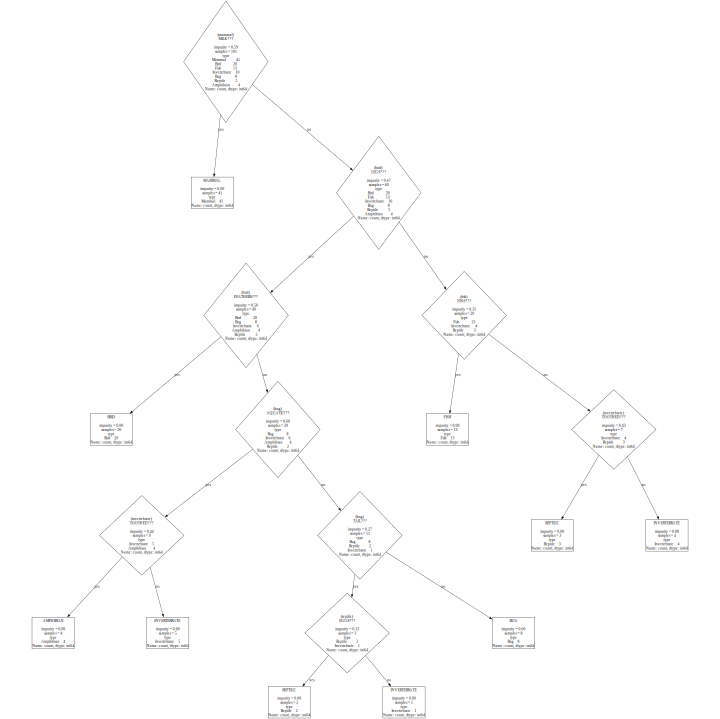

In [65]:
viz = model.to_graphviz(size='10,10')
viz.render('homebrew', format='pdf', cleanup=True)
viz

## Trees are sensitive


Let's make sure our data is loaded.

In [66]:
# Dataset adapted from https://archive.ics.uci.edu/ml/datasets/Zoo
url = 'https://raw.githubusercontent.com/MLCourse-LU/Datasets/main/zoo.csv'
df = pd.read_csv(filepath_or_buffer=url, header=0, index_col=0)

X = df.iloc[:, 1:-1]  # column 0 has the animal names, the last column has the labels
y = df.iloc[:, -1]  # use the last column as labels

Now, suppose you wanted to know whether the Gini or the Minority Class impurity measure was better for fitting the tree. And you're using accuracy to score your model performance with. You can run the code below to fit a model, then make some predictions with it and evaluate the accuracy.

**Try it multiple times, both for the Gini and the Minority Class model**

0.8823529411764706


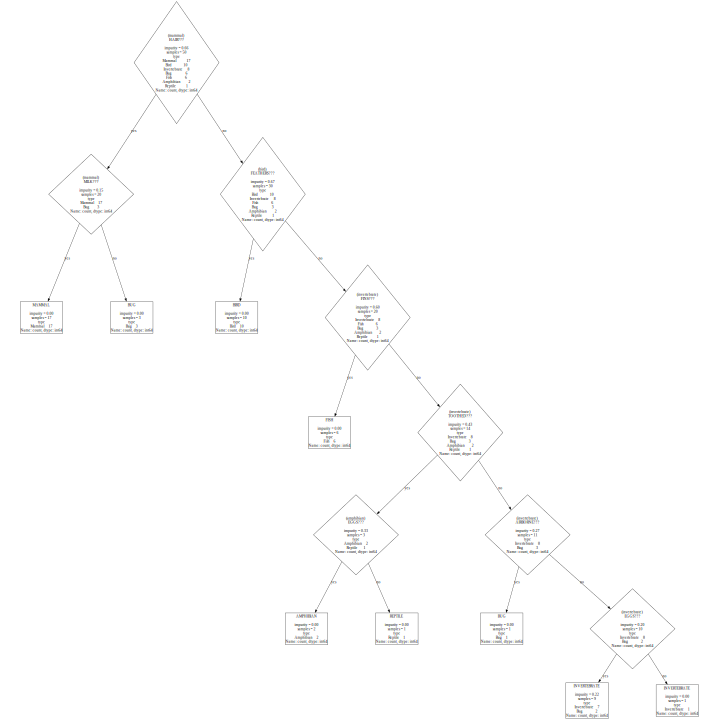

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
model = DTree(metric=minority_class)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
viz = model.to_graphviz(size='10,10')
viz.render('homebrew_gini', format='pdf', cleanup=True)
viz

0.4479166666666667
digraph Tree {
node [shape=box, style="filled", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="toothed <= 0.5\ngini = 0.48\nsamples = 5\nvalue = [2, 3]\nclass = Bird", fillcolor="#bddef6"] ;
1 [label="gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = Amphibian", fillcolor="#e58139"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = Bird", fillcolor="#399de5"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
}


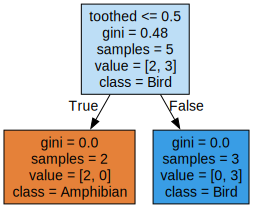

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
viz.render('homebrew_minority', format='pdf', cleanup=True)
dot = export_graphviz(
    decision_tree=model,  # the tree to visualize
    out_file=None,  # if None, return it as a string with "dot" information
    feature_names=fn,  # list of feature names
    class_names=sorted(cn),  # sorted! list of class names
    filled=True  # pretty colors
)

print(dot)  # "dot" is a string containing a structural description of our future graphic:
graph = graphviz.Source(dot)

# Print a copy to disk
graph.render('graphviz-tree', format='pdf', cleanup=True)  # save it as a file and clean up helper files

# Show the result if using a Notebook
graph

### Open Questions


(If you had trouble implementing the tree, you may also use a scikit-learn decision tree to figure out the answers to these questions. The results should be very similar.)

#### Question 3: Why are the trees not always the same?

#### Question 4: Choose a tree with particularly bad accuracy score. Put the graph as a picture in your report. Explain what you think may have happened during the fitting to make this such a bad model.

## Configuration using cross-validation

In machine learning we often want to know "what would be a good model type for this dataset?", or "given this model we want to use, how should we configure it?" But the examples above here showed that building just *one* tree on *one* way to split the data was not a reliable method to determine which choice of model/parameters was the best.

The obvious thing to try of course is just building more than one and taking the average. But if you just use the same data every time, you'll get the same tree too. Some other ML algorithms might also give you a different model even if you use the same data. In our implementation of the decision tree however, once you've decided which data you're going to train it on, the result is deterministic.

So what's really needed is doing more with our data. Specifically, we want to make sure every instance in our dataset is used at least once to test with. But we don't want to train our model on data that we're testing with. So we need some kind of rotation. And that's what cross-validation is, basically.

We often use $k$-fold cross validation, where $k$ is the number of "folds" we have. Each fold is a different way of splitting our dataset, and the *test set* in each fold is different from the test sets of all the other folds. So if we had 5-fold cross validation, each fold would use 20% of the data as a test set, and the rest as a training set. 

We then build our model $k$ times, so 5 different decision trees, and score each one on its test set. Then we aggregate those scores, for example by taking the average and also observing the standard deviation. These numbers are a better indication of how good our model/configuration choice is than a single run.

Consider the implementation of $k$-fold cross validation below:

In [69]:
class KFolds:
    def __init__(self, X, y, k, seed=None):
        """ Initialize the KFolds instance
        
        :param X: pd.DataFrame of feature columns 
        :param y: pd.DataFrame or pd.Series of labels
        :param k: number of folds desired
        :param seed: random seed, if you want reproducible results (optional)
        
        After initialization, self.folds will store k folds.
        Each fold is a pair of arrays with training indices and test indices.
        The folds are as evenly distributed in size as possible.
        All the test segments are pairwise disjoint.
        """
        self.X = X
        self.y = y
        self.k = k
        self.folds = []
        indices = np.arange(X.shape[0])  # integer indices of the instances
        if seed is not None:  # Set random seed if desired.
            np.random.seed(seed=seed)
        np.random.shuffle(indices)  # Shuffle in-place.
        fold_size = X.shape[0] / k  # How many instances per fold? Note that this is a floating point number!
        for fold_num in range(k):
            # The int() is used to handle the floating point numbers and make the segments as equal as possible.
            test = indices[int(fold_num * fold_size):int((fold_num + 1) * fold_size)]
            train = np.concatenate([indices[:int(fold_num * fold_size)], indices[int((fold_num + 1) * fold_size):]])
            self.folds.append((train, test))

    def get_fold(self, fold_num):
        """ Get the training and test data of the k-th fold
        
        :param fold_num: Which fold's division of the data to use
        :return: Training and test features/labels
        """
        train, test = self.folds[fold_num]  # Select the indices developed for this fold during initialization
        # Use those indices to select instance rows to send to test and training sets.
        X_train = self.X.iloc[train]
        X_test = self.X.iloc[test]
        y_train = self.y.iloc[train]
        y_test = self.y.iloc[test]
        return X_train, X_test, y_train, y_test

That's a big wall of code, how do you use it? A lot like our earlier `train_test_split` function, but now you request a specific fold:

In [70]:
folds = KFolds(X, y, k=5)  # set it up by putting data in
X_train, X_test, y_train, y_test = folds.get_fold(fold_num=3)  # Now get the data out, divided according to fold 3
X_train

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
ID,,,,,,,,,,,,,,,,
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
41,0,1,1,0,0,0,1,0,1,1,0,0,1,1,0,0
8,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
51,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0
85,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,0,0,1,0,0,1,1,1,1,0,0,1,0,0,1
21,0,1,1,0,1,1,0,0,1,1,0,0,1,1,0,0
54,1,0,0,1,0,0,1,1,1,1,0,0,1,1,0,0


You can use those folds of the dataset with your own decision tree, or with the Scikit-Learn implementation.

### Open Questions

#### Question 5: Make a table comparing the different model/configurations.
Write a loop that for a given value of $k$ applies k-fold cross validation with the zoo dataset. For $k=5$, report in a table the **mean** and **standard deviation** of the `accuracy_score` of each of the following:
* The Scikit-Learn tree, using Gini
* The Scikit-Learn tree, using Entropy
* Your own tree, using Gini
* Your own tree, using Entropy
* Your own tree, using Minority Class

(For full credit, do at least the Scikit-Learn trees or your own. Doing both counts as a bonus question.)

In [71]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
# Define models and configurations
models = {
    'sklearn-Gini': DecisionTreeClassifier(criterion='gini'),
    'sklearn-Entropy': DecisionTreeClassifier(criterion='entropy'),
    'bart-Gini': DTree(metric=gini),
    'bart-Entropy': DTree(metric=entropy),
    'bart-Minority': DTree(metric=minority_class)
}

# Define k-fold cross-validation
k=2
kf = KFolds(X,y,k)
# Evaluate models using cross-validation
results = {}
for model_name, model in models.items():
    scores = []
    for i in range(k):
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = kf.get_fold(i)

        # Train model and make predictions
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate accuracy score and store result
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
    
    # Store mean and standard deviation of scores
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    results[model_name] = (mean_score, std_score)

# Print results in a table
print(f'Model, Mean Std dev')
for model_name, (mean_score, std_score) in results.items():
    print(f'{str(model_name)[:6]}{str(mean_score)[:6]}{str(std_score)[:6]}')

Model, Mean Std dev
sklear0.92090.0190
sklear0.91130.0486
bart-G0.93090.0290
bart-E0.89170.0682
bart-M0.90190.0980


#### Question 6: which would you prefer? 
A high-accuracy model with large standard deviation, or a somewhat lower accuracy model with lower standard deviation? Explain why.

#### Question 7: Experiment with different values of $k$. 
What is the effect on the accuracy and standard deviation of using larger or smaller $k$? Why do you think that is?

### Comparing ours to theirs

You can also compare whether your models are working like they should by providing both your own `DTree` implementation and the Scikit-Learn `DecisionTreeClassifier` the same data and then using their text export functions to see what model they've learned:

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = DecisionTreeClassifier(criterion='gini')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'SK {accuracy_score(y_test, y_pred)}')
print(export_text(model, feature_names=fn))


model = DTree(gini)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Ours {accuracy_score(y_test, y_pred)}')
print(model.to_text())


SK 0.9230769230769231
|--- milk <= 0.50
|   |--- feathers <= 0.50
|   |   |--- fins <= 0.50
|   |   |   |--- airborne <= 0.50
|   |   |   |   |--- backbone <= 0.50
|   |   |   |   |   |--- class: Invertebrate
|   |   |   |   |--- backbone >  0.50
|   |   |   |   |   |--- tail <= 0.50
|   |   |   |   |   |   |--- class: Amphibian
|   |   |   |   |   |--- tail >  0.50
|   |   |   |   |   |   |--- aquatic <= 0.50
|   |   |   |   |   |   |   |--- class: Reptile
|   |   |   |   |   |   |--- aquatic >  0.50
|   |   |   |   |   |   |   |--- breathes <= 0.50
|   |   |   |   |   |   |   |   |--- class: Reptile
|   |   |   |   |   |   |   |--- breathes >  0.50
|   |   |   |   |   |   |   |   |--- class: Amphibian
|   |   |   |--- airborne >  0.50
|   |   |   |   |--- class: Bug
|   |   |--- fins >  0.50
|   |   |   |--- class: Fish
|   |--- feathers >  0.50
|   |   |--- class: Bird
|--- milk >  0.50
|   |--- class: Mammal

Ours 0.9230769230769231
|---milk = no
|   |---feathers = no
|   |   |---f

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = DecisionTreeClassifier(criterion='entropy')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'SK {accuracy_score(y_test, y_pred)}')
print(export_text(model, feature_names=fn))


model = DTree(entropy)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Ours {accuracy_score(y_test, y_pred)}')
print(model.to_text())

SK 0.9230769230769231
|--- milk <= 0.50
|   |--- feathers <= 0.50
|   |   |--- backbone <= 0.50
|   |   |   |--- airborne <= 0.50
|   |   |   |   |--- class: Invertebrate
|   |   |   |--- airborne >  0.50
|   |   |   |   |--- class: Bug
|   |   |--- backbone >  0.50
|   |   |   |--- fins <= 0.50
|   |   |   |   |--- aquatic <= 0.50
|   |   |   |   |   |--- class: Reptile
|   |   |   |   |--- aquatic >  0.50
|   |   |   |   |   |--- legs <= 0.50
|   |   |   |   |   |   |--- class: Reptile
|   |   |   |   |   |--- legs >  0.50
|   |   |   |   |   |   |--- class: Amphibian
|   |   |   |--- fins >  0.50
|   |   |   |   |--- class: Fish
|   |--- feathers >  0.50
|   |   |--- class: Bird
|--- milk >  0.50
|   |--- class: Mammal

Ours 0.9230769230769231
|---milk = no
|   |---feathers = no
|   |   |---backbone = no
|   |   |   |---airborne = no
|   |   |   |   |---INVERTEBRATE (8)
|   |   |   |---airborne = yes
|   |   |   |   |---BUG (4)
|   |   |---backbone = yes
|   |   |   |---fins = no
| 